# Explore and analyse the MSC and FSR reports

Much of this exploration and sentiment analysis will be a shortened version of the more longer FinBERT explantion already covered in the technical report and previous notebooks.

# 0. Library and package import, exploration

### Loading FinBERT enviroment

#### Importing model - [FinBert](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3910214)

In [1]:
# Import all the necessary packages.
!pip install transformers
!pip install torch torchvision torchaudio

import torch
import transformers
from transformers import BertTokenizer, BertForSequenceClassification

print(transformers.__version__)
print(torch.__version__)

NameError: name 'transformers' is not defined

#### Text Chunking to Handle BERT Token Limit
- BERT models have a token limit of 512. We will write a function to chunk the text appropriately.

In [ ]:
from nltk.tokenize import sent_tokenize

def chunk_text(text, max_length=510):  # Reserve 2 tokens for special tokens
    """
    Splits text into BERT-compatible chunks.
    """
    # Tokenize the text into sentences.
    sentences = sent_tokenize(text)
    current_chunk = []
    chunks = []
    
    for sentence in sentences:
        if len(current_chunk) + len(sentence.split()) <= max_length:
            current_chunk.extend(sentence.split())
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = sentence.split()
    
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    
    return chunks

#### Setting Up FinBERT

FinBERT is a pre-trained model by Hugging Face, tailored for financial sentiment analysis. We'll load the model and tokenizer here so we can call on it later

In [ ]:
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

 ## General library and package import, exploration

In [2]:
# Import all the necessary packages and libraries.
!pip install langdetect
from langdetect import detect, LangDetectException

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers
import nltk
nltk.download('punkt')

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\burts\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### A note on joining / concatenation 

> By avoiding joining/concatenation, we prevent the presence of NaNs and the subsequent need to address them. By conducting NLP analysis individually for each dataset, we maintain efficiency while retaining the option to combine the scores into one DataFrame at the end.

# -

## 1a. FSR Initial exploration and cleaning

In [3]:
# Load the CSV file into a DataFrame
fsr_data = pd.read_csv('financial_stability_reports.csv', sep=',')

In [4]:
# Viewing the fsr dataframe
fsr_data.head()

,Date,Full_Text
0,18/06/1999,Financial Stability Review June 1999 Bank of E...
1,26/11/1999,Financial Stability Review November 1999 Bank ...
2,29/06/2000,Financial Stability Review June 2000 Bank of E...
3,14/12/2000,Financial Stability Review December 2000 Bank ...
4,28/06/2001,Financial Stability Review June 2001 Bank of E...


In [5]:
# Rename the Full_Text column
fsr_data.rename(columns={'Full_Text': 'fsr_text', 'Date': 'date'}, inplace=True)

In [6]:
fsr_data.describe()

,date,fsr_text
count,48,48
unique,48,48
top,18/06/1999,Financial Stability Review June 1999 Bank of E...
freq,1,1


### Check characteristics of dataset

In [7]:
# Understand the characteristics of the dataset
fsr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      48 non-null     object
 1   fsr_text  48 non-null     object
dtypes: object(2)
memory usage: 900.0+ bytes


There are 48 reports, with 2 columns

> There are no duplicate values. We can proceed.

In [8]:
# Putting date into datetime format
fsr_data['date'] = pd.to_datetime(fsr_data['date'], format='%d/%m/%Y')

See below our views on the most appropriate datatypes for each clolumn:

- **date**: Datetime is best for future plotting and time series
- **fsr_text**: As this contains long textual data, 'object' datatype is the most appropriate for handling paragraphs of text

## 1b. Cleaning of data
To understand how many null cells there are in the dataset, it is important to first remove any leading or trailing spaces from each column (except for the date column, which we have converted and have confidence it contains datetime format data only). This will allow us to identify all 'true' null cells and get an accurate overview.

In [9]:
# Trim leading and trailing spaces from 'fsr_text' column
fsr_data['fsr_text'] = fsr_data['fsr_text'].str.strip()

# Check for null values in the dataset after trimming
null_counts = fsr_data.isnull().sum()

# Display the number of null cells in the dataset
print(null_counts)

date        0
fsr_text    0
dtype: int64


> There are no nulls

In [10]:
# Check for any duplicate rows in the DataFrame
duplicate_rows = fsr_data.duplicated().sum()

# Display the number of duplicate rows
print(f"Number of duplicate rows based on all columns: {duplicate_rows}")

Number of duplicate rows based on all columns: 0


> No duplicates

### 1c. Preparing data for NLP

There are a number of aspects we must keep in mind when preparing text for NLP. There are some checks required that applies to both analysis methods. Language, and removing noise such as urls.

#### Identify language of speeches to be able to filter for English speeches

In [11]:
# Function to detect language, returns 'unknown' if detection fails
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Apply the detect_language function to the 'fsr_text' column and check if all are English
all_english = fsr_data['fsr_text'].apply(detect_language).eq('en').all()
# Print the result
print("All texts are in English:", all_english)

All texts are in English: True


In [12]:
fsr_data.head()

,date,fsr_text
0,1999-06-18,Financial Stability Review June 1999 Bank of E...
1,1999-11-26,Financial Stability Review November 1999 Bank ...
2,2000-06-29,Financial Stability Review June 2000 Bank of E...
3,2000-12-14,Financial Stability Review December 2000 Bank ...
4,2001-06-28,Financial Stability Review June 2001 Bank of E...


> all the speeches are in English

#### Identify URLs, Hashtags, and mentions present in the dataset

In [13]:
# Check for URLs, hashtags and mentions

# Define regex patterns
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
hashtag_pattern = r'\#[\w\-]+'
mention_pattern = r'\@[\w\-]+'

# Count occurrences
url_count = fsr_data['fsr_text'].str.contains(url_pattern).sum()
hashtag_count = fsr_data['fsr_text'].str.contains(hashtag_pattern).sum()
mention_count = fsr_data['fsr_text'].str.contains(mention_pattern).sum()

print(f"URLs: {url_count}, Hashtags: {hashtag_count}, Mentions: {mention_count}")

URLs: 25, Hashtags: 3, Mentions: 13


In [14]:
# Filter rows where the text contains a URL
fsr_data_with_urls = fsr_data[fsr_data['fsr_text'].str.contains(url_pattern, na=False)]

# Save the filtered DataFrame to a CSV file
# fsr_data_with_urls.to_csv('fsr_data_with_urls.csv', index=False)

In [15]:
# Filter rows where the text contains a hashtag
fsr_data_with_hashtag = fsr_data[fsr_data['fsr_text'].str.contains(hashtag_pattern, na=False)]

# Save as CSV
# fsr_data_with_hashtag.to_csv('fsr_data_with_hashtag.csv', index=False)

In [16]:
# Filter rows where the text contains a mention (@)
fsr_data_with_mentions = fsr_data[fsr_data['fsr_text'].str.contains(mention_pattern, na=False)]

# Save the filtered DataFrame to a CSV file
# fsr_data_with_mentions.to_csv('fsr_data_with_mentions.csv', index=False)

Upon review of the output results, the mentions and hashtags do provide context to the text at hand, also there is very little frequency of this happening. Therefore we have kept these characters in as part of the analysis. URLs will be removed.
- FinBERT will be more than capable of finding any potential additional context that these extra pieces of data might provide

In [17]:
# Initialize an empty list to store information about removed URLs
removed_urls_info = []

# URL regex pattern
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# Function to remove URLs from a text string and report back the removed URLs
def remove_urls(text):
    global removed_urls_info
    # Find all URLs in the text
    found_urls = re.findall(url_pattern, text)
    # If URLs are found, store their info
    for url in found_urls:
        removed_urls_info.append(url)
    # Remove URLs from the text
    cleaned_text = re.sub(url_pattern, '', text)
    return cleaned_text

# Apply the function to the 'fsr_text' column to remove URLs
fsr_data['clean_fsr_text'] = fsr_data['fsr_text'].apply(remove_urls)

# Display the DataFrame with URLs removed
print(fsr_data[['date', 'clean_fsr_text']])

# Print the information about removed URLs
print("\nRemoved URLs Info:")
for url in removed_urls_info:
    print(f"Removed URL: {url}")

         date                                     clean_fsr_text
0  1999-06-18  Financial Stability Review June 1999 Bank of E...
1  1999-11-26  Financial Stability Review November 1999 Bank ...
2  2000-06-29  Financial Stability Review June 2000 Bank of E...
3  2000-12-14  Financial Stability Review December 2000 Bank ...
4  2001-06-28  Financial Stability Review June 2001 Bank of E...
5  2001-12-13  Financial Stability Review December 2001 Bank ...
6  2002-06-27  Financial Stability Review June 2002 Bank of E...
7  2002-12-12  Financial Stability Review December 2002 Bank ...
8  2003-06-26  Financial Stability Review June 2003 Bank of E...
9  2003-12-11  Financial Stability Review December 2003 Bank ...
10 2004-06-28  Financial Stability Review June 2004 Bank of E...
11 2004-12-13  Financial Stability Review December 2004 Bank ...
12 2005-06-22  Financial Stability Review June 2005 Bank of E...
13 2005-12-13  Financial Stability Review December 2005 Bank ...
14 2006-07-12  Financial 

### 1d. Pre-processing checks for FinBERT Analysis

- **Ensure text is in English** : We have tagged each speech for their language. 
- **Handle missing values**: There weren't any
- **Standardise text data** : FinBERT works well if the text is standardised (i.e. ensure consistent use of quotation markst etc). We will take the assumption that the use of quotation marks etc has been applied consistently.
- **Remove unnecessary elements**: It is good practice to remove URLs and other specific mark ups. However in the same vein, it is important not to over clean.
- **Ensure Data is in a Suitable Format**: The data is contained in a dataframe column. 

> The speech data is ready to have the model run on it

### 1e. Applying FinBERT to FSR Chunked Text

In [ ]:
# Define the analyse_sentiment function
def analyse_sentiment(text):
    model.eval()
    chunks = chunk_text(text)
    sentiments = []
    
    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiments.append(predictions.detach().numpy()[0])
    
    avg_sentiments = np.mean(sentiments, axis=0)
    sentiment_series = pd.Series(avg_sentiments, index=['neutral', 'positive', 'negative'])
    polarity_score = sentiment_series['positive'] - sentiment_series['negative']
    sentiment_series['polarity_score'] = polarity_score
    
    return sentiment_series

The Sentiment Analysis function does the following things:

Chunking the Text: 
- Divides the input text into smaller chunks to fit the model's maximum input size.

Processing Each Chunk:
- Tokenisation: Converts text chunks into a format suitable for the model using the tokeniser.
- Model Inference: Passes tokenized input through the model to obtain sentiment scores.
- Softmax Application: Converts raw scores into probabilities using softmax function.
- Aggregating Sentiment Scores: Averages sentiment probabilities across all chunks to represent overall sentiment.

Calculating Polarity Score: 
- Computes a single polarity score as the difference between positive and negative sentiment probabilities, providing a summary sentiment metric.

In [ ]:
# As it's a long calcualtion a progress bar is a useful measure. 
from tqdm import tqdm

# Enable tqdm progress bar for pandas apply
tqdm.pandas()

Now we have "analyse_sentiment" that returns the sentiment scores in the form [neutral, positive, negative] for a given text, we can loop through each text, apply analyse_sentiment, then calculate the polarity score using calculate_polarity. Finally, we'll store these polarity scores in a new column.

In [ ]:
# Apply the analyse_sentiment function to the all  entries of the dataset
fsr_finbert_polarity = fsr_data['fsr_text'].progress_apply(analyse_sentiment)

In [ ]:
# Expanding the results into the original DataFrame
fsr_data[['neutral', 'positive', 'negative', 'polarity_score']] = fsr_finbert_polarity

In [ ]:
fsr_data.head(15)

In [ ]:
# Renaming the vader_compound to vader_polarity for consistency with other models. 
fsr_data = fsr_data.rename(columns={'polarity_score': 'fsr_finbert_polarity'})

In [ ]:
# Renaming the neu, pos, neg columns for consistency with other models. 
fsr_data = fsr_data.rename(columns={'neutral': 'fsr_finbert_neutral', 'positive': 'fsr_finbert_positive', 'negative': 'fsr_finbert_negative',  })

In [ ]:
fsr_data.head(15)

In [ ]:
# Export DataFrame to CSV
fsr_data.to_csv('fsr_finbert_scores.csv', index=False)

# -

# 2a. Initial exploration and cleaning of MPC data

In [18]:
# Load the CSV file into a DataFrame
mpc_data = pd.read_csv('monetary_policy_reports.csv', sep=',')

In [19]:
# Viewing the mpc dataframe
mpc_data.head()

,Date,Full_Text
0,10/02/1999,Inflation Report February 1999 The Inflation R...
1,12/05/1999,Inflation Report May 1999 The Inflation Report...
2,11/08/1999,Inflation Report August 1999 The Inflation Rep...
3,10/11/1999,Inflation Report November 1999 The Inflation R...
4,17/02/2000,Inflation Report February 2000 The Inflation R...


In [20]:
# Rename the Full_Text column
mpc_data.rename(columns={'Full_Text': 'mpc_text', 'Date': 'date'}, inplace=True)

In [21]:
mpc_data.describe()

,date,mpc_text
count,96,96
unique,96,96
top,10/02/1999,Inflation Report February 1999 The Inflation R...
freq,1,1


### Check characteristics of dataset

In [22]:
# Understand the characteristics of the dataset
mpc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      96 non-null     object
 1   mpc_text  96 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


In [23]:
# Putting date into datetime format
mpc_data['date'] = pd.to_datetime(mpc_data['date'], format='%d/%m/%Y')

See below our views on the most appropriate datatypes for each clolumn:

- **date**: Datetime is best for future plotting and time series 
- **mpc_text**: As this contains long textual data, 'object' datatype is the most appropriate for handling paragraphs of text. 

## 2b. Cleaning of MPC data

To understand how many null cells there are in the dataset, it is important to first remove any leading or trailing spaces from each column (except for the date column, which we have converted and have confidence it contains datetime format data only). This will allow us to identify all 'true' null cells and get an accurate overview.

In [24]:
# Trim leading and trailing spaces from 'fsr_text' column
mpc_data['mpc_text'] = mpc_data['mpc_text'].str.strip()

# Check for null values in the dataset after trimming
null_counts = mpc_data.isnull().sum()

# Display the number of null cells in the dataset
print(null_counts)

date        0
mpc_text    0
dtype: int64


> There are no nulls

In [25]:
# Check for any duplicate rows in the DataFrame
duplicate_rows = mpc_data.duplicated().sum()

# Display the number of duplicate rows
print(f"Number of duplicate rows based on all columns: {duplicate_rows}")


Number of duplicate rows based on all columns: 0


> No duplicates

### 2c. Preparing MPC data for NLP

There are a number of aspects we must keep in mind when preparing text for NLP. There are some checks required that applies to both analysis methods. Language, and removing noise such as urls.

#### Identify language of speeches to be able to filter for English speeches

In [26]:
# Function to detect language, returns 'unknown' if detection fails
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Apply the detect_language function to the 'fsr_text' column and check if all are English
all_english = mpc_data['mpc_text'].apply(detect_language).eq('en').all()
# Print the result
print("All texts are in English:", all_english)

All texts are in English: True


In [27]:
mpc_data.head()

,date,mpc_text
0,1999-02-10,Inflation Report February 1999 The Inflation R...
1,1999-05-12,Inflation Report May 1999 The Inflation Report...
2,1999-08-11,Inflation Report August 1999 The Inflation Rep...
3,1999-11-10,Inflation Report November 1999 The Inflation R...
4,2000-02-17,Inflation Report February 2000 The Inflation R...


> all the speeches are in English

#### Identify URLs, Hashtags, and mentions present in the dataset

In [28]:
# Check for URLs, hashtags and mentions

# Define regex patterns
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
hashtag_pattern = r'\#[\w\-]+'
mention_pattern = r'\@[\w\-]+'

# Count occurrences
url_count = mpc_data['mpc_text'].str.contains(url_pattern).sum()
hashtag_count = mpc_data['mpc_text'].str.contains(hashtag_pattern).sum()
mention_count = mpc_data['mpc_text'].str.contains(mention_pattern).sum()

print(f"URLs: {url_count}, Hashtags: {hashtag_count}, Mentions: {mention_count}")

URLs: 13, Hashtags: 2, Mentions: 5


In [29]:
# Filter rows where the text contains a URL
mpc_data_with_urls = mpc_data[mpc_data['mpc_text'].str.contains(url_pattern, na=False)]

# Save the filtered DataFrame to a CSV file
# mpc_data_with_urls.to_csv('mpc_data_with_urls.csv', index=False)

In [30]:
# Filter rows where the text contains a hashtag
mpc_data_with_hashtag = mpc_data[mpc_data['mpc_text'].str.contains(hashtag_pattern, na=False)]

# Save as CSV
# mpc_data_with_hashtag.to_csv('mpc_data_with_hashtag.csv', index=False)

In [31]:
# Filter rows where the text contains a mention (@)
mpc_data_with_mentions = mpc_data[mpc_data['mpc_text'].str.contains(mention_pattern, na=False)]

# Save the filtered DataFrame to a CSV file
# mpc_data_with_mentions.to_csv('mpc_data_with_mentions.csv', index=False)

Upon review of the output results, the mentions and hashtags do provide context to the text at hand, also there is very little frequency of this happening. Therefore we have kept these characters in as part of the analysis. URLs will be removed.
- FinBERT will be more than capable of finding any potential additional context that these extra pieces of data might provide

In [32]:
# Initialize an empty list to store information about removed URLs
removed_urls_info = []

# URL regex pattern
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# Function to remove URLs from a text string and report back the removed URLs
def remove_urls(text):
    global removed_urls_info
    # Find all URLs in the text
    found_urls = re.findall(url_pattern, text)
    # If URLs are found, store their info
    for url in found_urls:
        removed_urls_info.append(url)
    # Remove URLs from the text
    cleaned_text = re.sub(url_pattern, '', text)
    return cleaned_text

# Apply the function to the 'mpc_text' column to remove URLs
mpc_data['clean_mpc_text'] = mpc_data['mpc_text'].apply(remove_urls)

# Display the DataFrame with URLs removed
print(mpc_data[['date', 'clean_mpc_text']])

# Print the information about removed URLs
print("\nRemoved URLs Info:")
for url in removed_urls_info:
    print(f"Removed URL: {url}")

         date                                     clean_mpc_text
0  1999-02-10  Inflation Report February 1999 The Inflation R...
1  1999-05-12  Inflation Report May 1999 The Inflation Report...
2  1999-08-11  Inflation Report August 1999 The Inflation Rep...
3  1999-11-10  Inflation Report November 1999 The Inflation R...
4  2000-02-17  Inflation Report February 2000 The Inflation R...
..        ...                                                ...
91 2021-11-04  Monetary Policy Committee Monetary Policy Repo...
92 2022-02-03  Monetary Policy Committee Monetary Policy Repo...
93 2022-05-05  Bank of England Monetary Policy Report  Moneta...
94 2022-08-04  Bank of England Monetary Policy Report  Moneta...
95 2022-11-03  Bank of England Monetary Policy Report Monetar...

[96 rows x 2 columns]

Removed URLs Info:
Removed URL: http://www.bankofengland.co.uk/
Removed URL: http://www.bankofengland.co.uk
Removed URL: http://www.bankofengland.co.uk/ir.htm
Removed URL: http://www.eia.doe.gov/c

### 2d. MPC Pre-processing checks for FinBERT Analysis

- **Ensure text is in English** : We have tagged each speech for their language. 
- **Handle missing values**: There weren't any
- **Standardise text data** : FinBERT works well if the text is standardised (i.e. ensure consistent use of quotation markst etc). We will take the assumption that the use of quotation marks etc has been applied consistently.
- **Remove unnecessary elements**: It is good practice to remove URLs and other specific mark ups. However in the same vein, it is important not to over clean.
- **Ensure Data is in a Suitable Format**: The data is contained in a dataframe column. 

> The speech data is ready to have the model run on it

### 2e. Applying FinBERT to MPC Chunked Text

In [ ]:
# Define the analyse_sentiment function
def analyse_sentiment(text):
    model.eval()
    chunks = chunk_text(text)
    sentiments = []
    
    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiments.append(predictions.detach().numpy()[0])
    
    avg_sentiments = np.mean(sentiments, axis=0)
    sentiment_series = pd.Series(avg_sentiments, index=['neutral', 'positive', 'negative'])
    polarity_score = sentiment_series['positive'] - sentiment_series['negative']
    sentiment_series['polarity_score'] = polarity_score
    
    return sentiment_series

The Sentiment Analysis function does the following things:

Chunking the Text: 
- Divides the input text into smaller chunks to fit the model's maximum input size.

Processing Each Chunk:
- Tokenisation: Converts text chunks into a format suitable for the model using the tokeniser.
- Model Inference: Passes tokenized input through the model to obtain sentiment scores.
- Softmax Application: Converts raw scores into probabilities using softmax function.
- Aggregating Sentiment Scores: Averages sentiment probabilities across all chunks to represent overall sentiment.

Calculating Polarity Score: 
- Computes a single polarity score as the difference between positive and negative sentiment probabilities, providing a summary sentiment metric.

Now we have "analyse_sentiment" that returns the sentiment scores in the form [neutral, positive, negative] for a given text, we can loop through each text, apply analyse_sentiment, then calculate the polarity score using calculate_polarity. Finally, we'll store these polarity scores in a new column.

In [ ]:
# Apply the analyse_sentiment function to the all  entries of the dataset
mpc_finbert_polarity = mpc_data['clean_mpc_text'].progress_apply(analyse_sentiment)

In [ ]:
# Expanding the results into the original DataFrame
mpc_data[['neutral', 'positive', 'negative', 'polarity_score']] = mpc_finbert_polarity

In [ ]:
mpc_data.head(15)

In [ ]:
# Renaming the vader_compound to vader_polarity for consistency with other models. 
mpc_data = mpc_data.rename(columns={'polarity_score': 'mpc_finbert_polarity'})

In [ ]:
# Renaming the neu, pos, neg columns for consistency with other models. 
mpc_data = mpc_data.rename(columns={'neutral': 'mpc_finbert_neutral', 'positive': 'mpc_finbert_positive', 'negative': 'mpc_finbert_negative',  })

In [ ]:
mpc_data.head(15)

In [ ]:
# Export DataFrame to CSV
mpc_data.to_csv('mpc_finbert_scores.csv', index=False)

# Exploration of FSR and MPC scores

### FSR viewing and cleaning

In [34]:
# Load the CSV file into a DataFrame
fsr_finbert_scores = pd.read_csv('fsr_finbert_scores.csv', sep=',')

In [35]:
# View the dataframe
fsr_finbert_scores.head()

,date,fsr_text,clean_fsr_text,fsr_finbert_neutral,fsr_finbert_positive,fsr_finbert_negative,fsr_finbert_polarity
0,18/06/1999,Financial Stability Review June 1999 Bank of E...,Financial Stability Review June 1999 Bank of E...,0.897825,0.039426,0.062749,-0.023323
1,26/11/1999,Financial Stability Review November 1999 Bank ...,Financial Stability Review November 1999 Bank ...,0.932477,0.026779,0.040744,-0.013965
2,29/06/2000,Financial Stability Review June 2000 Bank of E...,Financial Stability Review June 2000 Bank of E...,0.949606,0.028791,0.021603,0.007188
3,14/12/2000,Financial Stability Review December 2000 Bank ...,Financial Stability Review December 2000 Bank ...,0.923905,0.008724,0.067371,-0.058646
4,28/06/2001,Financial Stability Review June 2001 Bank of E...,Financial Stability Review June 2001 Bank of E...,0.923635,0.025830,0.050536,-0.024706


In [36]:
# Removing the finer polarity calculations of FinBERT and clean_text
columns_to_drop = ['clean_fsr_text', 'fsr_finbert_neutral', 'fsr_finbert_positive', 'fsr_finbert_negative', 'fsr_text']
fsr_finbert_scores.drop(columns=columns_to_drop, inplace=True)

In [37]:
# Checking for duplicates and NaNs
duplicates = fsr_finbert_scores.duplicated()
print("Number of duplicate rows:", duplicates.sum())

nan_values = fsr_finbert_scores.isna().sum()
print("Number of NaN values in each column:")
print(nan_values)

Number of duplicate rows: 0
Number of NaN values in each column:
date                    0
fsr_finbert_polarity    0
dtype: int64


In [38]:
# Descriptive statistics
fsr_finbert_scores.describe()

,fsr_finbert_polarity
count,48.000000
mean,-0.041992
std,0.085078
min,-0.421359
25%,-0.059071
50%,-0.025743
75%,-0.005050
max,0.157170


- Mean: The average sentiment score is approximately -0.041992, indicating a neutral sentiment overall
- Standard Deviation: The standard deviation is approximately 0.085078, suggesting low variability in sentiment scores.
- Minimum: The most negative sentiment score observed is approximately -0.421359, indicating a very low strongest negative sentiment.
- 25th Percentile: 25% of the scores are below approximately -0.059071
- Median (50th Percentile): The median sentiment score is approximately -0.025743
- 75th Percentile: 75% of the scores are below approximately -0.005050
- Maximum: The most positive sentiment score observed is approximately 0.157170

In [39]:
# Using the square root rule to find the number of bins
num_bins_fsr = int(np.sqrt(fsr_finbert_scores['fsr_finbert_polarity'].size))

print("FSR bins:", num_bins_fsr)

FSR bins: 6


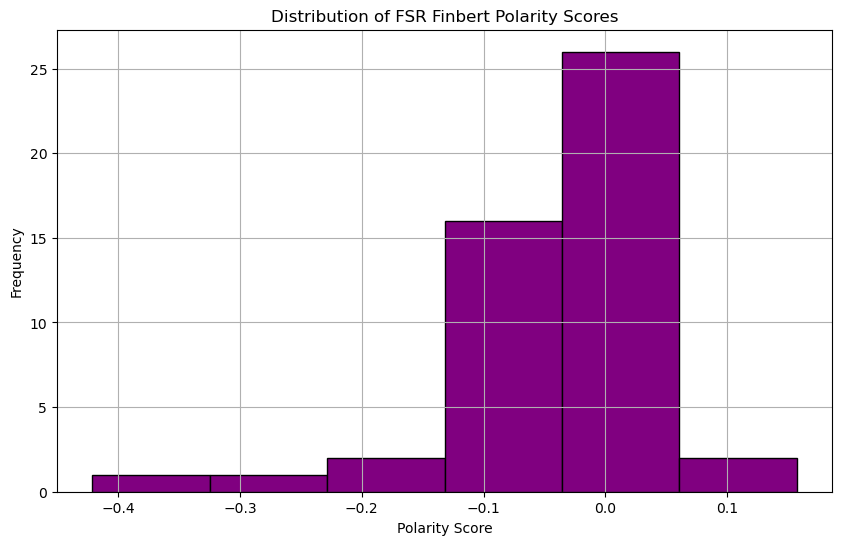

In [40]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(fsr_finbert_scores['fsr_finbert_polarity'], bins=6, color='purple', edgecolor='black')
plt.title('Distribution of FSR Finbert Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


> The distribution curve is not that good and the sentiment range is very limited, with most points clustered around neutral. There are a couple of quite negative reports.

In [41]:
# Export DataFrame to CSV
fsr_finbert_scores.to_csv('fsr_finbert_scores_final.csv', index=False)

### MPC viewing and cleaning

In [42]:
# Load the CSV file into a DataFrame
mpc_finbert_scores = pd.read_csv('mpc_finbert_scores.csv', sep=',')

In [43]:
# View the dataframe
mpc_finbert_scores.head()

,date,mpc_text,clean_mpc_text,mpc_finbert_neutral,mpc_finbert_positive,mpc_finbert_negative,mpc_finbert_polarity
0,1999-02-10,Inflation Report February 1999 The Inflation R...,Inflation Report February 1999 The Inflation R...,0.668095,0.051193,0.280712,-0.229519
1,1999-05-12,Inflation Report May 1999 The Inflation Report...,Inflation Report May 1999 The Inflation Report...,0.651095,0.137693,0.211212,-0.073518
2,1999-08-11,Inflation Report August 1999 The Inflation Rep...,Inflation Report August 1999 The Inflation Rep...,0.659348,0.238344,0.102308,0.136037
3,1999-11-10,Inflation Report November 1999 The Inflation R...,Inflation Report November 1999 The Inflation R...,0.585587,0.271822,0.142591,0.129230
4,2000-02-17,Inflation Report February 2000 The Inflation R...,Inflation Report February 2000 The Inflation R...,0.618752,0.289593,0.091655,0.197938


In [44]:
# Removing the finer polarity calculations of FinBERT and clean_text
columns_to_drop = ['clean_mpc_text', 'mpc_finbert_neutral', 'mpc_finbert_positive', 'mpc_finbert_negative', 'mpc_text']
mpc_finbert_scores.drop(columns=columns_to_drop, inplace=True)

In [45]:
# Checking for duplicates and NaNs
duplicates = mpc_finbert_scores.duplicated()
print("Number of duplicate rows:", duplicates.sum())

nan_values = mpc_finbert_scores.isna().sum()
print("Number of NaN values in each column:")
print(nan_values)

Number of duplicate rows: 0
Number of NaN values in each column:
date                    0
mpc_finbert_polarity    0
dtype: int64


In [46]:
# Descriptive statistics
mpc_finbert_scores.describe()

,mpc_finbert_polarity
count,96.000000
mean,-0.071532
std,0.111002
min,-0.346003
25%,-0.167058
50%,-0.069913
75%,-0.013296
max,0.197938


- Mean: The average sentiment score is approximately -0.071532, indicating strong neutrality
- Standard Deviation: The standard deviation is approximately 0.111002, suggesting low variability in sentiment scores.
- Minimum: The most negative sentiment score observed is approximately -0.346003, showing a reasonably low sentiment score.
- 25th Percentile: 25% of the scores are below approximately -0.167058, suggesting a quarter of the observations have moderately negative sentiment.
- Median (50th Percentile): The median sentiment score is approximately -0.069913
- 75th Percentile: 75% of the scores are below approximately -0.013296, 
- Maximum: The most positive sentiment score observed is approximately 0.197938

In [47]:
# Using the square root rule to find the number of bins
num_bins_mpc = int(np.sqrt(mpc_finbert_scores['mpc_finbert_polarity'].size))

print("MPC bins:", num_bins_mpc)

MPC bins: 9


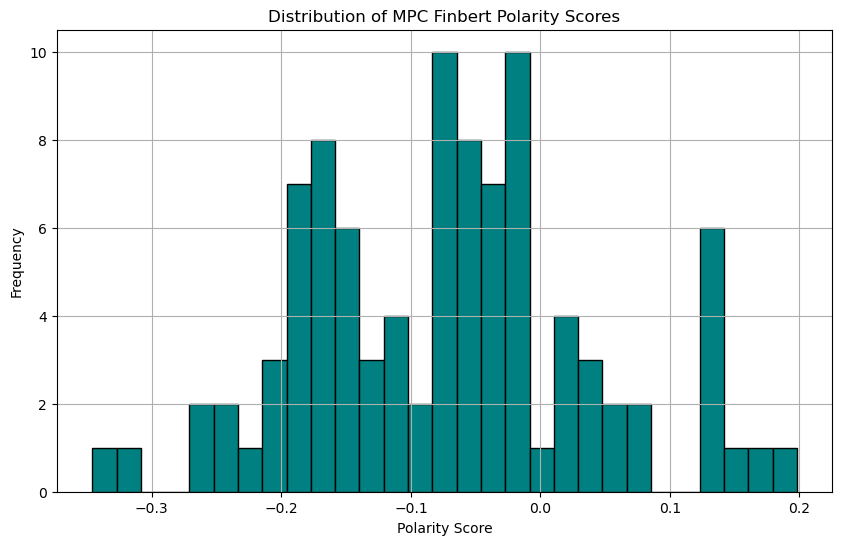

In [48]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(mpc_finbert_scores['mpc_finbert_polarity'], bins=29, color='teal', edgecolor='black')
plt.title('Distribution of MPC Finbert Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

> The distribution curve is not encouraging, however the range is healthier even though it is negatively skewed. 

In [49]:
# Export DataFrame to CSV
mpc_finbert_scores.to_csv('mpc_finbert_scores_final.csv', index=False)

# Word clouds

### FSR

#### Preparing FSR wordcloud by adding the clean text column back in

In [50]:
fsr_data.head() 

,date,fsr_text,clean_fsr_text
0,1999-06-18,Financial Stability Review June 1999 Bank of E...,Financial Stability Review June 1999 Bank of E...
1,1999-11-26,Financial Stability Review November 1999 Bank ...,Financial Stability Review November 1999 Bank ...
2,2000-06-29,Financial Stability Review June 2000 Bank of E...,Financial Stability Review June 2000 Bank of E...
3,2000-12-14,Financial Stability Review December 2000 Bank ...,Financial Stability Review December 2000 Bank ...
4,2001-06-28,Financial Stability Review June 2001 Bank of E...,Financial Stability Review June 2001 Bank of E...


In [51]:
fsr_finbert_scores.head()

# Putting date into datetime format
fsr_finbert_scores['date'] = pd.to_datetime(fsr_finbert_scores['date'], format='%d/%m/%Y')

In [52]:
fsr_wordcloud = pd.merge(fsr_finbert_scores, fsr_data[['date', 'clean_fsr_text']], on='date', how='left')

In [53]:
fsr_wordcloud.head()

,date,fsr_finbert_polarity,clean_fsr_text
0,1999-06-18,-0.023323,Financial Stability Review June 1999 Bank of E...
1,1999-11-26,-0.013965,Financial Stability Review November 1999 Bank ...
2,2000-06-29,0.007188,Financial Stability Review June 2000 Bank of E...
3,2000-12-14,-0.058646,Financial Stability Review December 2000 Bank ...
4,2001-06-28,-0.024706,Financial Stability Review June 2001 Bank of E...


In [54]:
# Descriptive statistics
fsr_wordcloud.describe()

,fsr_finbert_polarity
count,48.000000
mean,-0.041992
std,0.085078
min,-0.421359
25%,-0.059071
50%,-0.025743
75%,-0.005050
max,0.157170


Given the descriptive statistics and the distribution above, it seems correct to set our thresholds around the interquartile range to better capture the more clearly positive or negative sentiments. For instance:

- Negative Threshold: Could be set around the 25% quartile, say at -0.059, to ensure that only the speeches that are clearly negative are classified as such.
- Positive Threshold: Could be set around the 75% quartile, for example, at 0, to classify a speech as positive only if it has a clearly positive sentiment.

#### Top 30 most positive FSR words

In [55]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer

# Download necessary resources from NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# Set of English stop words
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Filter the DataFrame to include only rows with positive FinBERT polarity scores
fsr_pos_words = fsr_wordcloud[fsr_wordcloud['fsr_finbert_polarity'] > -0.059]

# Concatenate the text from the 'clean_fsr_text' column into a single string
fsr_merge_pos = ' '.join(fsr_pos_words['clean_fsr_text'])

# Lowercasing and removing non-alphabetic characters
fsr_merge_pos = re.sub(r'[^a-zA-Z\s]', '', fsr_merge_pos.lower())

# Split the merged text into words
fsr_merge_pos_words = fsr_merge_pos.split()

# Remove stop words and short words, and apply lemmatization
fsr_filtered_words = [lemmatizer.lemmatize(word) for word in fsr_merge_pos_words if word not in stop_words and len(word) > 2]

# Calculate the frequency of each word
fsr_word_counts = Counter(fsr_filtered_words)

# Sort the words by frequency in descending order
fsr_sorted_words = sorted(fsr_word_counts.items(), key=lambda x: x[1], reverse=True)

# Selecting the top 30 positive words
fsr_top_pos_words = fsr_sorted_words[:30]

# Display the top positive words
print(fsr_top_pos_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\burts\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\burts\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[('bank', 31499), ('financial', 19218), ('market', 14202), ('risk', 14033), ('chart', 9338), ('capital', 8500), ('stability', 8296), ('rate', 7842), ('credit', 7788), ('asset', 7059), ('system', 6791), ('source', 6140), ('may', 6045), ('debt', 5636), ('sector', 5481), ('review', 5298), ('loan', 5040), ('also', 5034), ('lending', 5009), ('year', 4957), ('banking', 4776), ('price', 4697), ('ratio', 4541), ('per', 4427), ('exposure', 4254), ('data', 4103), ('equity', 4080), ('bond', 4070), ('cent', 4018), ('mortgage', 4007)]


In [56]:
# Top 30 negative fsr words

# Filter the DataFrame to include only rows with negative FinBERT polarity scores (less than 0)
fsr_neg_words = fsr_wordcloud[fsr_wordcloud['fsr_finbert_polarity'] < 0]

# Concatenate the text from the 'clean_fsr_text' column into a single string
fsr_merge_neg = ' '.join(fsr_neg_words['clean_fsr_text'])

# Lowercasing and removing non-alphabetic characters
fsr_merge_neg = re.sub(r'[^a-zA-Z\s]', '', fsr_merge_neg.lower())

# Split the merged text into words
fsr_merge_neg_words = fsr_merge_neg.split()

# Remove stop words and short words, and apply lemmatization
fsr_filtered_words = [lemmatizer.lemmatize(word) for word in fsr_merge_neg_words if word not in stop_words and len(word) > 2]

# Calculate the frequency of each word
fsr_word_counts = Counter(fsr_filtered_words)

# Sort the words by frequency in descending order
fsr_sorted_words = sorted(fsr_word_counts.items(), key=lambda x: x[1], reverse=True)

# Selecting the top 30 negative words
fsr_top_neg_words = fsr_sorted_words[:30]

# Display the top negative words
print(fsr_top_neg_words)

[('bank', 31202), ('financial', 17820), ('market', 14267), ('risk', 13185), ('chart', 8854), ('capital', 8677), ('credit', 7806), ('rate', 7526), ('stability', 7347), ('asset', 7168), ('system', 6214), ('source', 5807), ('may', 5519), ('debt', 5389), ('sector', 4996), ('lending', 4913), ('loan', 4878), ('also', 4872), ('price', 4677), ('ratio', 4605), ('year', 4529), ('banking', 4521), ('mortgage', 4168), ('data', 4153), ('fund', 4124), ('review', 4088), ('bond', 4013), ('exposure', 3961), ('household', 3890), ('equity', 3885)]


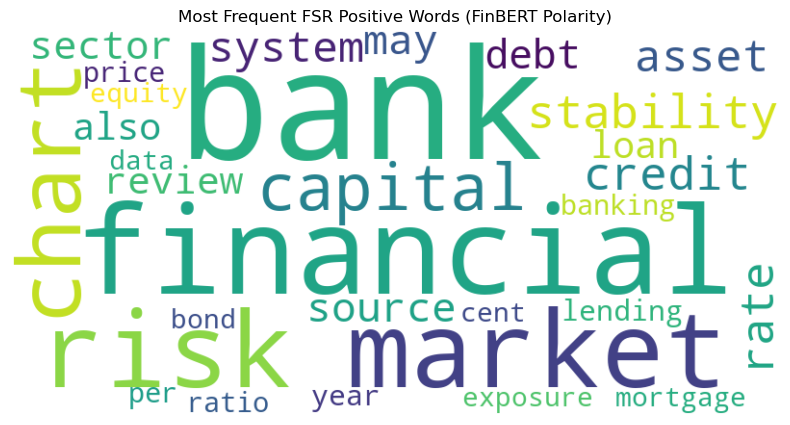

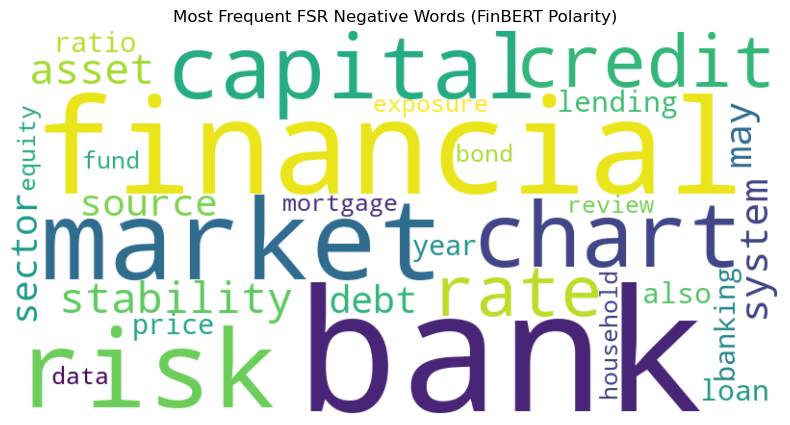

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud for most frequent positive words
wordcloud_pos_fsr = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(fsr_top_pos_words))

# Plot the word cloud for positive words
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos_fsr, interpolation='bilinear')
plt.title('Most Frequent FSR Positive Words (FinBERT Polarity)')
plt.axis('off')
plt.show()

# Generate word cloud for most frequent negative words
wordcloud_neg_fsr = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(fsr_top_neg_words))

# Plot the word cloud for negative words
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg_fsr, interpolation='bilinear')
plt.title('Most Frequent FSR Negative Words (FinBERT Polarity)')
plt.axis('off')
plt.show()

#### Positive Section

Unique Words:

- Per (4,427): Likely used in contexts discussing percentages or specific measurements, which may carry a neutral or slightly positive connotation.
- Cent (4,018): Similar to "per," often part of financial data presentation, implying stability or precise information.

More Frequent Words:

- Financial (13,998): Central to FSR, often associated with stability and positive developments.
- Risk (848): Surprisingly, appears more in positive contexts, possibly discussed in terms of risk management or mitigation successes.
- Stability (949): Directly correlates with the core aims of financial oversight and assurance.
- System (577): References to systemic aspects of banking, suggesting discussions on robustness and reliability.
- May (526): Indicates speculative or potential positive outcomes or scenarios.
- Review (1,210): Implicates thorough examination and control processes, reassuring stakeholders.


### Negative Section:

Unique Words:

- Fund (4,124): May relate to specific financial instruments or reserves, possibly discussed in contexts of insufficiency or stress.
- Household (3,890): Typically associated with vulnerabilities or stress in consumer finance segments.

#### Insights on Sentiment Themes

Positive Insights:

- Emphasise further analysis and discussions on financial stability, risk management strategies, and systematic strengths to maintain positive sentiments.

Negative Insights:

- Address issues related to funds management and household financial stability to alleviate negative sentiments.

In [58]:
# Calculate the number of words in 'clean_fsr_text'
fsr_wordcloud['speech_length'] = fsr_wordcloud['clean_fsr_text'].apply(lambda x: len(x.split()))

# Define thresholds for positive and negative speeches
threshold_positive = -0.059
threshold_negative = 0 

# Filter the DataFrame for positive and negative speeches
positive_fsr_reports = fsr_wordcloud[fsr_wordcloud['fsr_finbert_polarity'] > threshold_positive]
negative_fsr_reports = fsr_wordcloud[fsr_wordcloud['fsr_finbert_polarity'] < threshold_negative]

# Calculate the average length of speeches in each category
average_fsr_length_positive = positive_fsr_reports['speech_length'].mean()
average_fsr_length_negative = negative_fsr_reports['speech_length'].mean()

# Count the total number of positive and negative reports
total_positive_reports = positive_fsr_reports.shape[0]
total_negative_reports = negative_fsr_reports.shape[0]

# Print the average lengths and total counts
print(f"Average length of positive FSR reports: {average_fsr_length_positive:.2f} words")
print(f"Average length of negative FSR reports: {average_fsr_length_negative:.2f} words")
print(f"Total number of positive FSR reports: {total_positive_reports}")
print(f"Total number of negative FSR reports: {total_negative_reports}")

Average length of positive FSR reports: 63910.72 words
Average length of negative FSR reports: 56645.51 words
Total number of positive FSR reports: 36
Total number of negative FSR reports: 39


> The reports are roughly the same in terms of both average word length and number when sorted by the IQR polarity. 

### MPC

In [59]:
mpc_data.head() 

,date,mpc_text,clean_mpc_text
0,1999-02-10,Inflation Report February 1999 The Inflation R...,Inflation Report February 1999 The Inflation R...
1,1999-05-12,Inflation Report May 1999 The Inflation Report...,Inflation Report May 1999 The Inflation Report...
2,1999-08-11,Inflation Report August 1999 The Inflation Rep...,Inflation Report August 1999 The Inflation Rep...
3,1999-11-10,Inflation Report November 1999 The Inflation R...,Inflation Report November 1999 The Inflation R...
4,2000-02-17,Inflation Report February 2000 The Inflation R...,Inflation Report February 2000 The Inflation R...


In [60]:
mpc_finbert_scores.head()

,date,mpc_finbert_polarity
0,1999-02-10,-0.229519
1,1999-05-12,-0.073518
2,1999-08-11,0.136037
3,1999-11-10,0.129230
4,2000-02-17,0.197938


In [61]:
# Putting date into datetime format
mpc_finbert_scores['date'] = pd.to_datetime(mpc_finbert_scores['date'], format='%Y-%m-%d')

In [62]:
mpc_wordcloud = pd.merge(mpc_finbert_scores, mpc_data[['date', 'clean_mpc_text']], on='date', how='left')

In [63]:
# Descriptive statistics
mpc_wordcloud.describe()

,mpc_finbert_polarity
count,96.000000
mean,-0.071532
std,0.111002
min,-0.346003
25%,-0.167058
50%,-0.069913
75%,-0.013296
max,0.197938


Given the descriptive statistics and the distribution above, it seems correct to set our thresholds around the interquartile range to better capture the more clearly positive or negative sentiments. For instance:

- Negative Threshold: Could be set around the 25% quartile, say at -0.17, to ensure that only the speeches that are clearly negative are classified as such.
- Positive Threshold: Could be set around the 75% quartile, for example, at 0, to classify a speech as positive only if it has a clearly positive sentiment.

In [68]:
# Top 30 positive mpc words

# Filter the DataFrame to include only rows with positive FinBERT polarity scores (greater than 0)
mpc_pos_words = mpc_wordcloud[mpc_wordcloud['mpc_finbert_polarity'] > 0]

# Concatenate the text from the 'clean_mpc_text' column into a single string
mpc_merge_pos = ' '.join(mpc_pos_words['clean_mpc_text'])

# Lowercasing and removing non-alphabetic characters
mpc_merge_pos = re.sub(r'[^a-zA-Z\s]', '', mpc_merge_pos.lower())

# Split the merged text into words
mpc_merge_pos_words = mpc_merge_pos.split()

# Remove stop words and short words, and apply lemmatisation
mpc_filtered_words_pos = [lemmatizer.lemmatize(word) for word in mpc_merge_pos_words if word not in stop_words and len(word) > 2]

# Calculate the frequency of each word
mpc_pos_word_counts = Counter(mpc_filtered_words_pos)

# Sort the words by frequency in descending order
mpc_pos_sorted_words = sorted(mpc_pos_word_counts.items(), key=lambda x: x[1], reverse=True)

# Selecting the top 30 positive words
mpc_top_pos_words = mpc_pos_sorted_words[:30]

# Display the top positive words
print(mpc_top_pos_words)

[('growth', 7173), ('rate', 6456), ('price', 6353), ('inflation', 6193), ('chart', 4401), ('year', 3777), ('bank', 3069), ('market', 2892), ('report', 2722), ('projection', 2449), ('may', 2372), ('average', 2347), ('gdp', 2227), ('demand', 2146), ('sector', 2078), ('interest', 2049), ('month', 2031), ('output', 1994), ('percentage', 1904), ('since', 1883), ('change', 1882), ('survey', 1828), ('household', 1817), ('data', 1786), ('labour', 1747), ('increase', 1744), ('rise', 1741), ('investment', 1664), ('also', 1611), ('cost', 1560)]


In [70]:
# Top 30 negative mpc words

# Filter the DataFrame to include only rows with negative FinBERT polarity scores (less than 0)
mpc_neg_words = mpc_wordcloud[mpc_wordcloud['mpc_finbert_polarity'] < -0.17]

# Concatenate the text from the 'clean_mpc_text' column into a single string
mpc_merge_neg = ' '.join(mpc_neg_words['clean_mpc_text'])

# Lowercasing and removing non-alphabetic characters
mpc_merge_neg = re.sub(r'[^a-zA-Z\s]', '', mpc_merge_neg.lower())

# Split the merged text into words
mpc_merge_neg_words = mpc_merge_neg.split()

# Remove stop words and short words, and apply lemmatization
mpc_filtered_words = [lemmatizer.lemmatize(word) for word in mpc_merge_neg_words if word not in stop_words and len(word) > 2]

# Calculate the frequency of each word
mpc_word_counts = Counter(mpc_filtered_words)

# Sort the words by frequency in descending order
mpc_sorted_words = sorted(mpc_word_counts.items(), key=lambda x: x[1], reverse=True)

# Selecting the top 30 negative words
mpc_top_neg_words = mpc_sorted_words[:30]

# Display the top negative words
print(mpc_top_neg_words)

[('inflation', 5862), ('growth', 5850), ('price', 5804), ('rate', 4978), ('chart', 4634), ('bank', 4425), ('year', 3147), ('market', 2804), ('report', 2656), ('may', 2488), ('gdp', 2431), ('demand', 2357), ('projection', 2180), ('average', 2125), ('output', 2106), ('sector', 2033), ('household', 2019), ('survey', 1928), ('data', 1904), ('also', 1873), ('likely', 1872), ('since', 1830), ('month', 1826), ('labour', 1711), ('fall', 1707), ('service', 1593), ('cost', 1582), ('increase', 1576), ('percentage', 1564), ('change', 1526)]


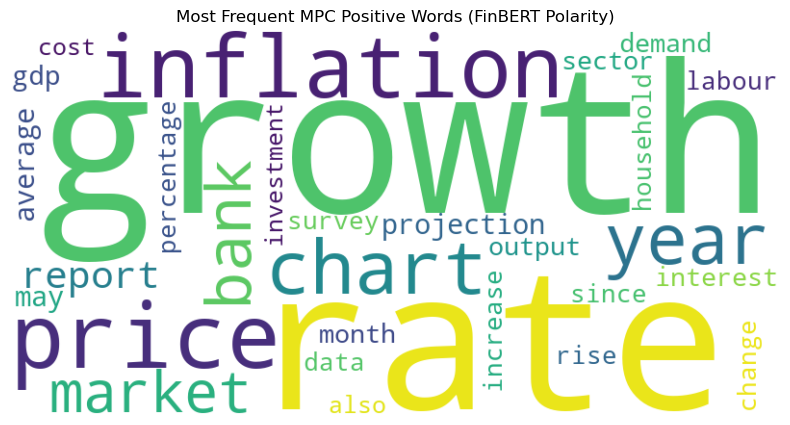

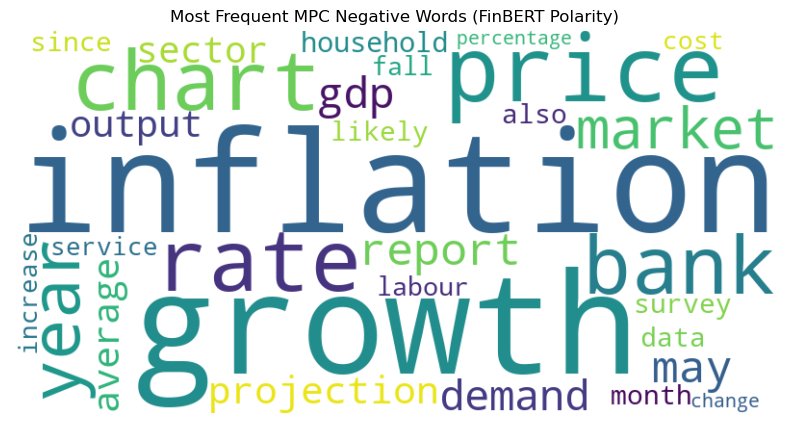

In [71]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud for most frequent positive words
wordcloud_pos_mpc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(mpc_top_pos_words))

# Plot the word cloud for positive words
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos_mpc, interpolation='bilinear')
plt.title('Most Frequent MPC Positive Words (FinBERT Polarity)')
plt.axis('off')
plt.show()

# Generate word cloud for most frequent negative words
wordcloud_neg_mpc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(mpc_top_neg_words))

# Plot the word cloud for negative words
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg_mpc, interpolation='bilinear')
plt.title('Most Frequent MPC Negative Words (FinBERT Polarity)')
plt.axis('off')
plt.show()

#### Positive Section

Unique Words

- Interest (2049): Likely associated with positive financial outcomes or rewarding investment returns.
- Investment (1664): Suggests forward-looking, growth-oriented financial activities.
- Rise (1741): Typically refers to growth in economic indicators like prices or rates, perceived positively..

More Frequent Words
- Growth (7173): Reflects economic expansion, often seen as a primary indicator of healthy economic conditions.
- Rate (6456): Can be tied to interest rates, where a favorable rate is indicative of good economic management.
- Price (6353): In a positive context, may indicate stability or reasonable inflation levels.
- Year (3777): Often used in discussions of annual progress or achievements.
- Interest (2049): Also appears as a unique word; its frequency underlines its importance in financial discussions.
- Rise (1741): As a more frequent word, it underscores positive growth trends.
- Investment (1664): Emphasizes proactive financial strategies and economic optimism.

#### Negative Section

Unique Words

- Fall (1707): Often associated with declines in economic indicators, viewed negatively.
- Likely (1872): In negative contexts, may refer to the probable occurrence of undesirable events.
- Service (1593): Can imply issues in service industries or burdens caused by service sector problems.

More Frequent Words
- Bank (4425): In negative contexts, could be associated with failures, bailouts, or crises.
- Likely (1872): Reflects the anticipation or risk of negative developments.
- Fall (1707): Reinforces concerns about economic downturns or falling markets.
- Service (1593): If frequent in negative contexts, may highlight systemic issues within service-oriented sectors.

#### Insights on Sentiment Themes

Positive Economic Activity
- Positive sentiment in the Bank of England's MPC reports is often linked to terms that convey economic strength and forward-looking optimism. Words like "growth," "investment," and "rise" reflect a focus on economic expansion and robust financial health. These terms are not only frequent but convey a narrative of proactive financial management and the anticipation of favorable economic outcomes.

Economic Challenges and Risks
- Negative sentiment revolves around terms associated with economic setbacks or uncertainties. "Fall," "bank," and "likely" frequently appear in contexts that discuss declines, potential financial instability, or adverse economic conditions. These words highlight areas of concern within the economy, focusing on risks and the potential for negative outcomes, which could influence public and investor perceptions negatively.

#### Frequency difference

In [67]:
# Let's consider the average speech length to see a comparison of composition. 

# Calculate the number of words in 'clean_mpc_text'
mpc_wordcloud['speech_length'] = mpc_wordcloud['clean_mpc_text'].apply(lambda x: len(x.split()))

# Define thresholds for positive and negative speeches
threshold_positive = 0.0  # Assuming polarity > 0 is positive
threshold_negative = -0.17  # Assuming polarity < -0.17 is negative

# Filter the DataFrame for positive and negative speeches
positive_mpc_reports = mpc_wordcloud[mpc_wordcloud['mpc_finbert_polarity'] > threshold_positive]
negative_mpc_reports = mpc_wordcloud[mpc_wordcloud['mpc_finbert_polarity'] < threshold_negative]

# Calculate the average length of speeches in each category
average_mpc_length_positive = positive_mpc_reports['speech_length'].mean()
average_mpc_length_negative = negative_mpc_reports['speech_length'].mean()

# Count the total number of positive and negative reports
total_positive_reports = positive_mpc_reports.shape[0]
total_negative_reports = negative_mpc_reports.shape[0]

# Print the average lengths
print(f"Average length of positive reports: {average_mpc_length_positive:.2f} words")
print(f"Average length of negative reports: {average_mpc_length_negative:.2f} words")
print(f"Total number of positive reports: {total_positive_reports}")
print(f"Total number of negative reports: {total_negative_reports}")

Average length of positive reports: 36842.00 words
Average length of negative reports: 33596.95 words
Total number of positive reports: 20
Total number of negative reports: 22
